<a href="https://colab.research.google.com/github/gokmenkilic/ML-Intro/blob/gk%2Ftests/Material_Generating_Graphene_EM_Images_(VAEs)_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Generating Graphene EM Images using Variational Autoencoders (VAEs).

In this notebook, we attempt to build Variational Autoencoders (VAEs) to generate new samples plausibly drawn from the training dataset.

Inelastic neutron scattering (INS) can be used to infer information about the forces present in a material. Neutrons scatter off a sample, exchanging energy with certain fundamental vibrational modes of the sample. These vibraional modes include phonons (interatomic boding forces) and magnons (spin coupling between magnetic nuclei).

[Johnstone et al. (2012)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.109.237202) have simulated magnon spectra from a double perovskite systems, where INS was used to distinguish between two possible magnetic Hamiltonians of the system. For this practical, we have simulated datasets for each of the possible Hamiltonians. We are going to train a CNN to classify the system correctly.


The aim of this work is to make a disentangled variational autoencoder ($\beta$-VAE) to generate new images from the INS dataset, using CNNs for encoding and decoding.

Compared to a simple VAE, a $\beta$-VAE only introduce one hyperparameter $\beta$ to the loss function to balance the effects of the reconstruction loss and the variational loss. A simple VAE is the special case with $\beta=1$.

In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import urllib.request
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from os.path import join

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)

Using TensorFlow v2.19.0


### Data Setup & Google Colab Environment

The dataset is hosted publicly by DiRAC on COSMA. **Please make sure you run the cell below to download the data.**

To access the data from COSMA, you need to:

1. Run the first cell;
2. It will create a folder called sciml-workshop-data.
3. It will download the necessary HDF5 files directly into that folder.
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# data setup configuration
data_path = 'sciml-workshop-data'
full_dir = os.path.join(data_path, 'ins-data')
os.makedirs(full_dir, exist_ok=True)

base_url = "https://virgodb.cosma.dur.ac.uk/public/dc-kili1/sciml-workshop-data/ins-data/"
files_to_download = ["train.h5"]

In [3]:
for filename in files_to_download:
    path = os.path.join(full_dir, filename)

    if not os.path.exists(path):
        urllib.request.urlretrieve(base_url + filename, path)

---

# 1. Load the dataset

### Read raw data

We have already split the data into training and validation sets and saved them into two HDF5 files, `ins-data/train.h5`, containing 20,000 INS images.

### The `tf.data.Dataset` class
The number of images is so large that we may not be able to simultaneously load the whole dataset into memory on a small machine. To solve this issue, we will use [tensorflow.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) to create an interface pointing to the files, which can load the data from disk on the fly when they are actually required.



<_FlatMapDataset element_spec=(TensorSpec(shape=(None, 20, 200, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


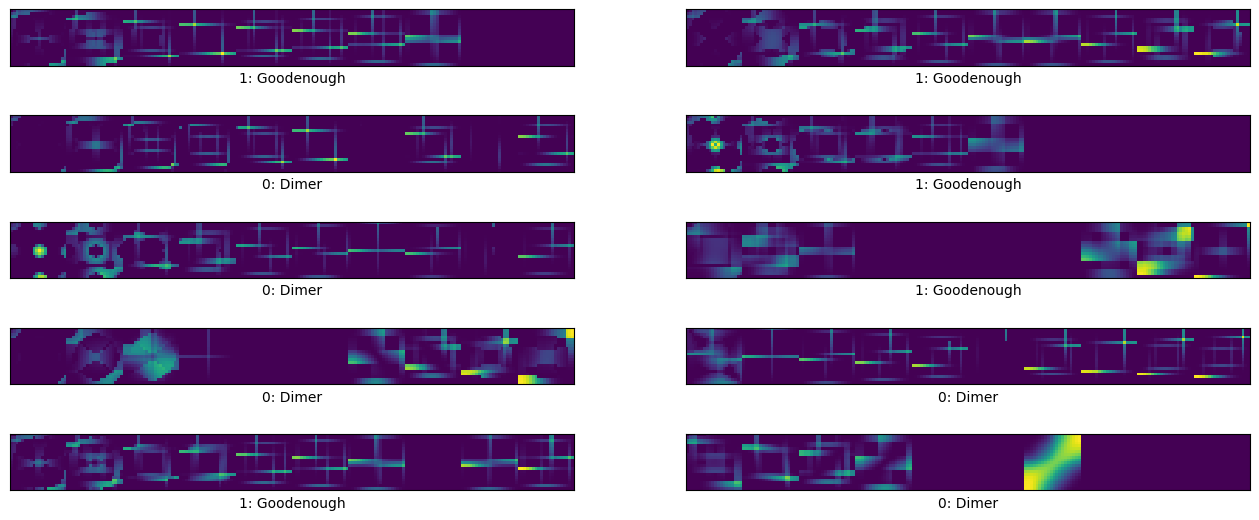

In [4]:
# define image size
IMG_HEIGHT = 20
IMG_WIDTH = 200
N_CHANNELS = 1
N_CLASSES = 2

# generator
def hdf5_generator(path, buffer_size=32):
    """ Load data INS data from disk

    Args:
        path: path of the HDF5 file on disk
        buffer_size: number of images to read from disk
    """
    with h5py.File(path, 'r') as handle:
        n_samples, h, w, c = handle['images'].shape
        for i in range(0, n_samples, buffer_size):
            images = handle['images'][i:i+buffer_size, ..., :1]
            labels = handle['labels'][i:i+buffer_size]
            yield images, labels

# training data
train_dataset = tf.data.Dataset.from_generator(lambda: hdf5_generator(path=join(data_path, 'ins-data/train.h5')),
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=((None, IMG_HEIGHT, IMG_WIDTH, N_CHANNELS),
                                                              (None, N_CLASSES,)))

# print
print(train_dataset)
# load the first buffer (with 32 data by default)
images, labels = list(train_dataset.take(1))[0]

# plot some images and labels from it
nplot = 10
fig, axes = plt.subplots(nplot // 2, 2, figsize=(16, nplot / 1.5), dpi=100)
for ax, image, label in zip(axes.flatten(), images, labels):
    ax.matshow(np.squeeze(image))
    ax.set_xlabel('0: Dimer' if label[0] < .5 else '1: Goodenough', c='k')
    ax.set_xticks([])
    ax.set_yticks([])

---

# 2. Build the network


### $\beta$-VAE for Image Generation

This $\beta$-VAE can be a combination of the CNN architecture and conventional VAE.

Our image size is `(20, 20)`. The inputs and outputs should have the same size as the images. An additional hyperparameter $\beta$ is introduced in a loss function.


### Encoder and decoder

First, we need to specify the latent dimension:

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# latent dimension
latent_dim = 32
```
    
</p>
</details>

In [5]:
# latent dimension
latent_dim = 32

Now, extend the CNN to an encoder and a decoder.

**Suggested Answer for Encoder**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# sampling z with (z_mean, z_log_var)
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# build the encoder
image_input = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS))
x = layers.Conv2D(8, kernel_size=(5, 5), activation='relu', padding='same')(image_input)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z_output = Sampling()([z_mean, z_log_var])
encoder_BVAE = keras.Model(image_input, [z_mean, z_log_var, z_output])
encoder_BVAE.summary()
```
    
</p>
</details>


In [6]:
# sampling z with (z_mean, z_log_var)
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# build the encoder
image_input = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS))
x = layers.Conv2D(8, kernel_size=(5, 5), activation='relu', padding='same')(image_input)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z_output = Sampling()([z_mean, z_log_var])
encoder_BVAE = keras.Model(image_input, [z_mean, z_log_var, z_output])
encoder_BVAE.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20, 200,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 20, 200,   │        208 │ input_layer[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 10, 100,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 10, 100,   │         32 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 10, 100,   │      1,168 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 5, 50, 16) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 50, 16) │         64 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 5, 50, 16) │      2,320 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 2, 25, 16) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 25, 16) │         64 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 800)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 32)        │     25,632 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 32)        │     25,632 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 32)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,120 (215.31 KB)

 Trainable params: 55,040 (215.00 KB)

 Non-trainable params: 80 (320.00 B)

**Suggested Answer for Decoder**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# build the decoder
z_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(800, activation="relu")(z_input)
x = layers.Reshape((2, 25, 16))(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2DTranspose(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.ZeroPadding2D((1, 0))(x)
x = layers.Conv2DTranspose(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2DTranspose(8, kernel_size=(5, 5), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
image_output = layers.Conv2DTranspose(1, kernel_size=(3, 3), activation='linear', padding='same')(x)
decoder_BVAE = keras.Model(z_input, image_output)
decoder_BVAE.summary()
```
    
</p>
</details>

In [7]:
# build the decoder
z_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(800, activation="relu")(z_input)
x = layers.Reshape((2, 25, 16))(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2DTranspose(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.ZeroPadding2D((1, 0))(x)
x = layers.Conv2DTranspose(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2DTranspose(8, kernel_size=(5, 5), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
image_output = layers.Conv2DTranspose(1, kernel_size=(3, 3), activation='linear', padding='same')(x)
decoder_BVAE = keras.Model(z_input, image_output)
decoder_BVAE.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 800)            │        26,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 2, 25, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 4, 50, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 50, 16)      │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 50, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 8, 100, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 10, 100, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 10, 100, 16)    │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 100, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 20, 200, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 20, 200, 8)     │         3,208 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 20, 200, 8)     │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 20, 200, 1)     │            73 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,481 (134.69 KB)

 Trainable params: 34,401 (134.38 KB)

 Non-trainable params: 80 (320.00 B)

### Training Loop

The `BVAE` class can be the same as implemented in [VAE_basics.ipynb](VAE_basics.ipynb) except that we need to pass and use $\beta$.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# BVAE class
class BVAE(keras.Model):
    # constructor
    ########################################################
    ######## NEW: passing beta as an extra argument ########
    ########################################################
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(BVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    # customise train_step() to implement the loss
    def train_step(self, x):
        if isinstance(x, tuple):
            x = x[0]
        with tf.GradientTape() as tape:
            # encoding
            z_mean, z_log_var, z = self.encoder(x)
            # decoding
            x_prime = self.decoder(z)
            # reconstruction error by binary crossentropy loss
            reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(x, x_prime))
            reconstruction_loss *= IMG_HEIGHT * IMG_WIDTH
            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            # loss = reconstruction error + KL divergence
            #######################################
            ######## NEW: scale KL by beta ########
            #######################################
            loss = reconstruction_loss + self.beta * kl_loss
        # apply gradient
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # return loss for metrics log
        return {"loss": loss,
                "reconstruction_loss": reconstruction_loss,
                "beta_kl_loss": self.beta * kl_loss}
```
    
</p>
</details>

In [8]:
# BVAE class
class BVAE(keras.Model):
    # constructor
    ########################################################
    ######## NEW: passing beta as an extra argument ########
    ########################################################
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(BVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    # customise train_step() to implement the loss
    def train_step(self, x):
        if isinstance(x, tuple):
            x = x[0]
        with tf.GradientTape() as tape:
            # encoding
            z_mean, z_log_var, z = self.encoder(x)
            # decoding
            x_prime = self.decoder(z)
            # reconstruction error by binary crossentropy loss
            reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(x, x_prime))
            reconstruction_loss *= IMG_HEIGHT * IMG_WIDTH
            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            # loss = reconstruction error + KL divergence
            #######################################
            ######## NEW: scale KL by beta ########
            #######################################
            loss = reconstruction_loss + self.beta * kl_loss
        # apply gradient
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # return loss for metrics log
        return {"loss": loss,
                "reconstruction_loss": reconstruction_loss,
                "beta_kl_loss": self.beta * kl_loss}

### Build and train the `BVAE` model

Now, build the `BVAE` model and train it with the INS dataset. Let us first use $\beta=5$ and start with 50 epochs.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# build the BVAE
bvae_model = BVAE(encoder_BVAE, decoder_BVAE, beta=5.)

# compile the BVAE
bvae_model.compile(optimizer='adam')

# train the BVAE
training_history_BAVE = bvae_model.fit(train_dataset, epochs=50, batch_size=32)
```
    
</p>
</details>

In [9]:
# build the BVAE
bvae_model = BVAE(encoder_BVAE, decoder_BVAE, beta=5.)

# compile the BVAE
bvae_model.compile(optimizer='adam')

# train the BVAE
training_history_BAVE = bvae_model.fit(train_dataset, epochs=50, batch_size=32)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - beta_kl_loss: 8.3662 - loss: 769.9028 - reconstruction_loss: 761.5366
Epoch 2/50
 14/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - beta_kl_loss: 10.4654 - loss: 673.4880 - reconstruction_loss: 663.0226

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - beta_kl_loss: 10.3158 - loss: 654.5606 - reconstruction_loss: 644.2448
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - beta_kl_loss: 10.5879 - loss: 626.3373 - reconstruction_loss: 615.7495
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - beta_kl_loss: 10.6135 - loss: 611.5138 - reconstruction_loss: 600.9003
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - beta_kl_loss: 10.5624 - loss: 611.1599 - reconstruction_loss: 600.5975
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - beta_kl_loss: 10.9520 - loss: 599.0715 - reconstruction_loss: 588.1195
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - beta_kl_loss: 10.9343 - loss: 586.2561 - reconstruction_loss: 575.3218
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - beta_kl_loss: 10.8976 - loss: 582.4335 - reconstruction_loss: 571.5358
Epoch 9/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - beta_kl_loss: 10.8470 - loss: 569.7628 - reconstruction_loss: 558.9157
Epoch 10/50

# 3. Analyse results

Finally, we can generate new images using the decoder. After 50 epochs, the generated images resemble the original ones but look pretty vague. We can increase the definition by using more convolutional layers and a larger latent dimension (and thus more epochs) and by tuning the value of $\beta$.



**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# generate images from the latent space
def generate_images_latent(decoder, n_generation, feature_range):
    # randomly sample the latent space
    latent = []
    for dim in range(latent_dim):
        if len(np.array(feature_range).shape) == 1:
            # only one range provided; used it for all dimensions
            latent.append(np.random.uniform(feature_range[0], feature_range[1],
                                            n_generation))
        else:
            # range provided for each dimension
            latent.append(np.random.uniform(feature_range[dim][0], feature_range[dim][1],
                                            n_generation))
    latent = np.array(latent).T

    # decode images
    decodings = decoder.predict(latent)

    # plot generated images
    fig, axes = plt.subplots(n_generation // 2, 2, figsize=(16, n_generation / 2), dpi=100)
    for ax, image in zip(axes.flatten(), decodings):
        ax.matshow(image[:, :, 0])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()  

# generate random images sampled between [-1, 1]
generate_images_latent(decoder_BVAE, n_generation=30, feature_range=[-1, 1])
```
    
</p>
</details>


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


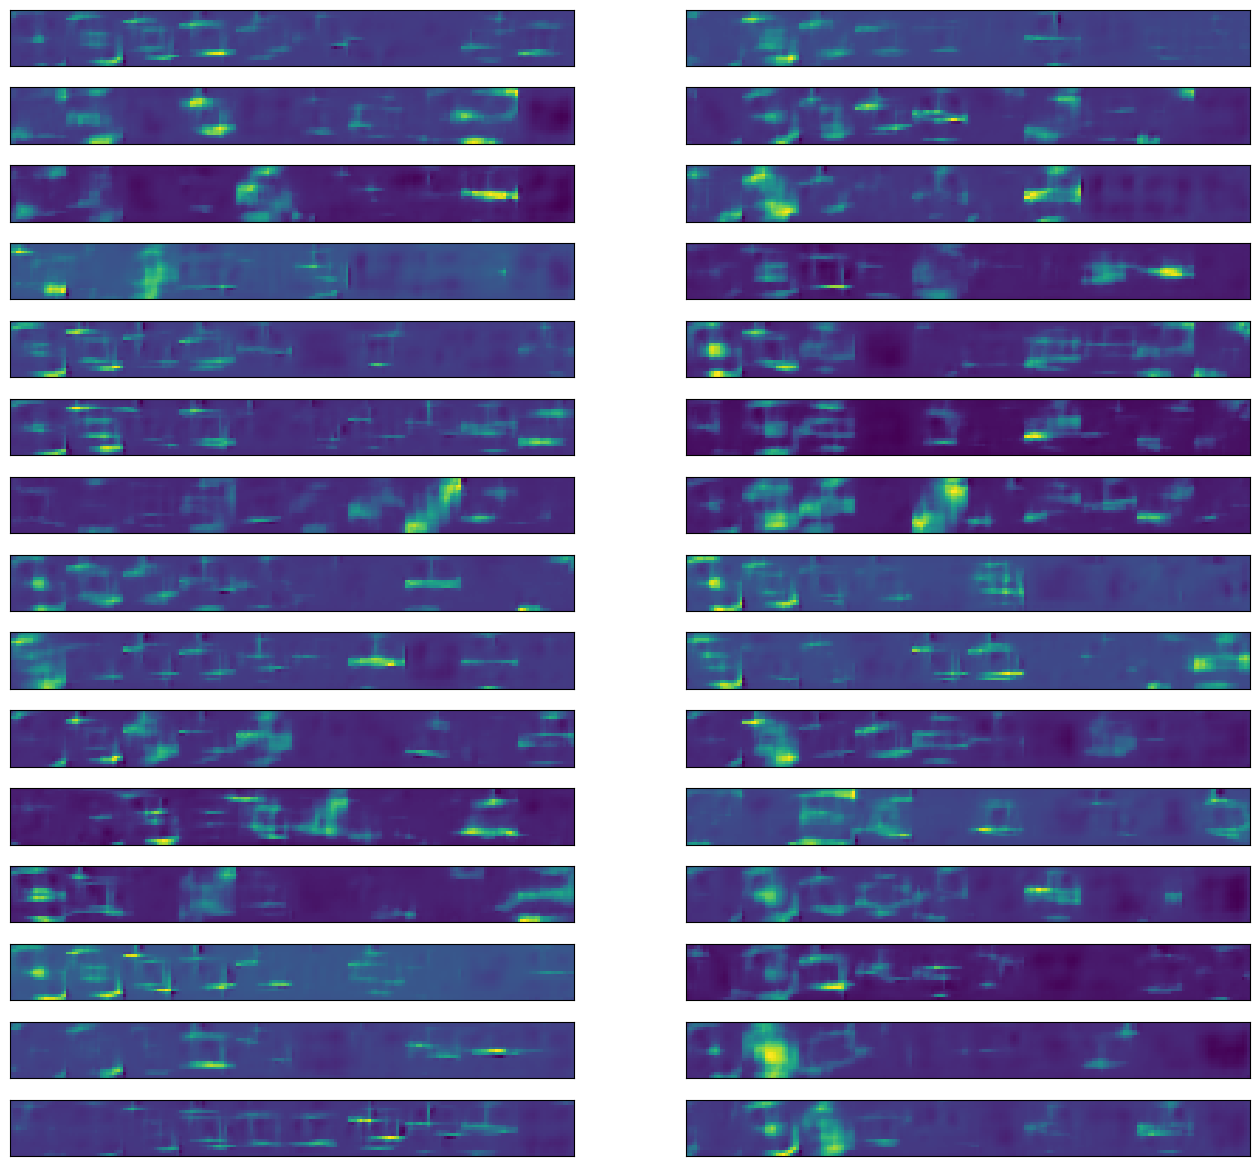

In [10]:
# generate images from the latent space
def generate_images_latent(decoder, n_generation, feature_range):
    # randomly sample the latent space
    latent = []
    for dim in range(latent_dim):
        if len(np.array(feature_range).shape) == 1:
            # only one range provided; used it for all dimensions
            latent.append(np.random.uniform(feature_range[0], feature_range[1],
                                            n_generation))
        else:
            # range provided for each dimension
            latent.append(np.random.uniform(feature_range[dim][0], feature_range[dim][1],
                                            n_generation))
    latent = np.array(latent).T

    # decode images
    decodings = decoder.predict(latent)

    # plot generated images
    fig, axes = plt.subplots(n_generation // 2, 2, figsize=(16, n_generation / 2), dpi=100)
    for ax, image in zip(axes.flatten(), decodings):
        ax.matshow(image[:, :, 0])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

# generate random images sampled between [-1, 1]
generate_images_latent(decoder_BVAE, n_generation=30, feature_range=[-1, 1])

---

# 4. Exercises:

1. Tune `latent_dim` and `beta` (and use more epochs) to improve the quality of image generation.
2. Implement a conditional VAE for this INS dataset.